# 이상치 유지(제거 X) 버전

# 1. 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
padua_data = pd.read_csv('../data/kideny_PADUA_upload.csv')
renal_data = pd.read_csv('../data/kideny_RENAL_upload.csv')
treat_data = pd.read_csv('../data/kidney_treat_upload.csv')

# 2. 데이터 정리
중복 컬럼 삭제(종양의 크기, 외성장 비율) 및 데이터 합치기

In [3]:
# padua_data, renal_data 데이터 merge
merged_data = pd.merge(padua_data, renal_data, on='serial')
# padua 에서 중복 컬럼 삭제
merged_data = merged_data.drop(['Tumor_PADUA', 'Exophytic_PADUA'], axis=1)
# treat 데이터 merge
merged_result = pd.merge(merged_data, treat_data, on='serial', how='left')
# serial을 인덱스로 설정
merged_result.set_index('serial', inplace=True)

## 컬럼명 변경

In [4]:
merged_result = merged_result.rename(columns={'Radius_RENAL': 'T_size', 'Exophytic_RENAL':'T_exophytic',
                            'Rim_PADUA':'T_surface_loc','Polarlocation_PADUA':'T_height_loc',
                            'Collectingsystem_PADUA':'T_GM_over','Sinus_PADUA':'T_Sinus_dt',
                            'Nearness_RENAL':'T_near_Ureter','APX_RENAL':'T_APX','Location_RENAL':'T_rel_Ureter','RAIV_1': 'RAIV'
                            })

## 결측치 삭제

In [5]:
merged_result = merged_result.dropna()
merged_result

,T_surface_loc,T_Sinus_dt,T_height_loc,T_GM_over,PADUA_total,T_size,T_exophytic,T_near_Ureter,T_APX,T_rel_Ureter,RENAL_total,RAIV
serial,,,,,,,,,,,,
1,2.0,1.0,1.0,1.0,8,2.0,1.0,1.0,2.0,1.0,4,51.1
2,1.0,1.0,2.0,1.0,8,1.0,2.0,2.0,2.0,2.0,5,46.1
3,1.0,1.0,2.0,1.0,7,1.0,1.0,1.0,1.0,1.0,3,14.8
4,1.0,1.0,2.0,2.0,8,1.0,1.0,3.0,2.0,3.0,5,19.7
5,1.0,1.0,2.0,1.0,8,1.0,2.0,1.0,1.0,3.0,4,14.8
...,...,...,...,...,...,...,...,...,...,...,...,...
408,1.0,1.0,2.0,1.0,8,1.0,2.0,1.0,1.0,3.0,4,21.3
409,1.0,1.0,2.0,1.0,8,1.0,2.0,1.0,1.0,3.0,4,30.5
410,1.0,1.0,1.0,1.0,7,1.0,2.0,1.0,1.0,1.0,4,70.7


## 컬럼 생성

- PADUA_total , RENAL_total 삭제
- 하나의 total 점수생성(PADUA_total + RENAL_total)

In [6]:
merged_result['Total'] = merged_result[['PADUA_total', 'RENAL_total']].sum(axis=1)
merged_result.drop(columns=['PADUA_total', 'RENAL_total'], inplace=True)

merged_result.head()

,T_surface_loc,T_Sinus_dt,T_height_loc,T_GM_over,T_size,T_exophytic,T_near_Ureter,T_APX,T_rel_Ureter,RAIV,Total
serial,,,,,,,,,,,
1,2.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,51.1,12
2,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,46.1,13
3,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,14.8,10
4,1.0,1.0,2.0,2.0,1.0,1.0,3.0,2.0,3.0,19.7,13
5,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,3.0,14.8,12


In [7]:
# 새로운 컬럼(T_size + T_Exophytic = T_size_exo )
merged_result['T_size_exo'] = merged_result['T_size'] + merged_result['T_exophytic']

In [8]:
merged_result = merged_result[['T_surface_loc', 'T_Sinus_dt', 'T_height_loc', 'T_GM_over', 'T_size', 'T_exophytic', 'T_near_Ureter', 'T_rel_Ureter', 'T_APX', 'Total', 'T_size_exo', 'RAIV']]
merged_result

,T_surface_loc,T_Sinus_dt,T_height_loc,T_GM_over,T_size,T_exophytic,T_near_Ureter,T_rel_Ureter,T_APX,Total,T_size_exo,RAIV
serial,,,,,,,,,,,,
1,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,12,3.0,51.1
2,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,13,3.0,46.1
3,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,10,2.0,14.8
4,1.0,1.0,2.0,2.0,1.0,1.0,3.0,3.0,2.0,13,2.0,19.7
5,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,12,3.0,14.8
...,...,...,...,...,...,...,...,...,...,...,...,...
408,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,12,3.0,21.3
409,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,12,3.0,30.5
410,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,11,3.0,70.7


In [9]:
merged_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 389 entries, 1 to 412
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   T_surface_loc  389 non-null    float64
 1   T_Sinus_dt     389 non-null    float64
 2   T_height_loc   389 non-null    float64
 3   T_GM_over      389 non-null    float64
 4   T_size         389 non-null    float64
 5   T_exophytic    389 non-null    float64
 6   T_near_Ureter  389 non-null    float64
 7   T_rel_Ureter   389 non-null    float64
 8   T_APX          389 non-null    float64
 9   Total          389 non-null    int64  
 10  T_size_exo     389 non-null    float64
 11  RAIV           389 non-null    float64
dtypes: float64(11), int64(1)
memory usage: 39.5 KB


# 3. 데이터 탐색(EDA)

In [10]:
merged_result.head()

,T_surface_loc,T_Sinus_dt,T_height_loc,T_GM_over,T_size,T_exophytic,T_near_Ureter,T_rel_Ureter,T_APX,Total,T_size_exo,RAIV
serial,,,,,,,,,,,,
1,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,12,3.0,51.1
2,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,13,3.0,46.1
3,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,10,2.0,14.8
4,1.0,1.0,2.0,2.0,1.0,1.0,3.0,3.0,2.0,13,2.0,19.7
5,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,12,3.0,14.8


In [11]:
merged_result.describe()

,T_surface_loc,T_Sinus_dt,T_height_loc,T_GM_over,T_size,T_exophytic,T_near_Ureter,T_rel_Ureter,T_APX,Total,T_size_exo,RAIV
count,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000
mean,1.354756,1.318766,1.398458,1.311054,1.208226,1.868895,1.920308,1.799486,1.557841,13.449871,3.077121,27.196144
std,0.479055,0.466598,0.490211,0.485253,0.471162,0.718521,0.906064,0.806481,0.497283,2.964686,0.811779,24.330815
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,2.000000,3.500000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.000000,2.000000,10.800000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,13.000000,3.000000,19.000000
75%,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,3.000000,2.000000,2.000000,16.000000,4.000000,35.100000
max,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,21.000000,5.000000,154.800000


## 각 변수들의 분포도 시각화

In [12]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create a grid of subplots, 3 columns wide
fig = make_subplots(rows=4, cols=3, subplot_titles=merged_result.columns)

# Iterate through each variable and create a histogram for it
for i, col in enumerate(merged_result.columns):
    hist_trace = go.Histogram(x=merged_result[col])
    fig.add_trace(hist_trace, row=i // 3 + 1, col=i % 3 + 1)

# Update layout
fig.update_layout(height=600, width=900, title_text="Histograms of Variables")

# Show plot
fig.show()


In [13]:
# Raiv에 대한 histogram
import plotly.express as px

fig=px.histogram(merged_result, x='RAIV')
fig.show()

## 상관관계

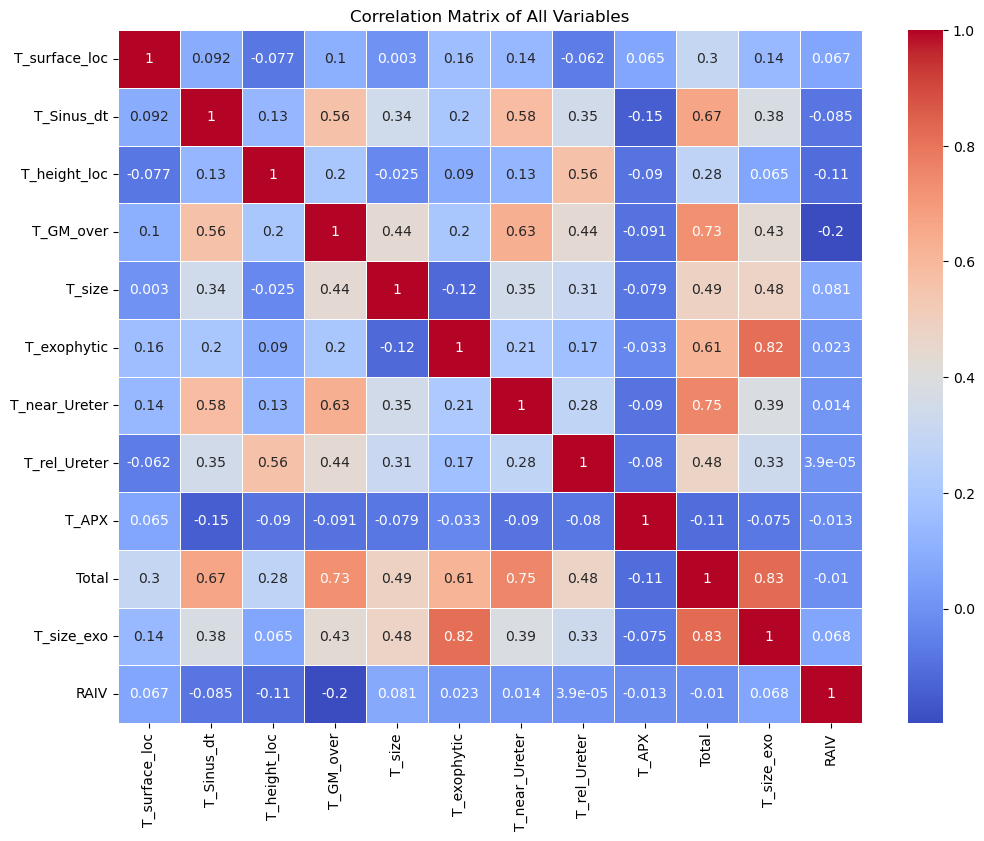

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get all numeric columns
numeric_columns = merged_result.select_dtypes(include=['int64', 'float64']).columns

# Create a correlation matrix
correlation_matrix = merged_result[numeric_columns].corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, annot=True, linewidths=.5, cmap="coolwarm")
plt.title("Correlation Matrix of All Variables")
plt.show()

## boxplot

In [15]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Box(y=merged_result['RAIV'], name='RAIV'))
fig.show()

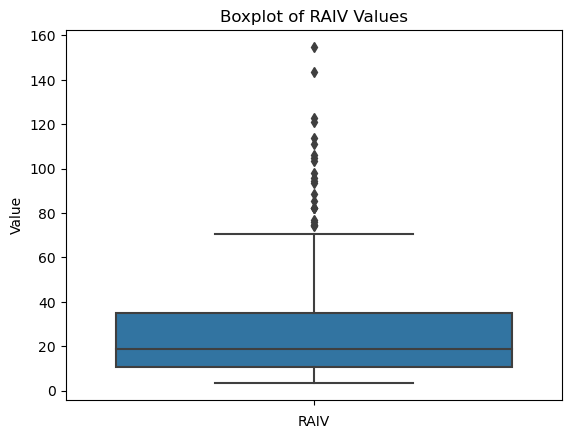

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot of the RAIV_1 variable
sns.boxplot(data=merged_result, y="RAIV")

# Add a title and labels
plt.title("Boxplot of RAIV Values")
plt.xlabel("RAIV")
plt.ylabel("Value")

# Show the plot
plt.show()


---

### T_size(종양 크기 	≤4 ; 4-7 ; 7)에 따른 Raiv 

In [17]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=merged_result['RAIV'], y=merged_result['T_size'], mode='markers', name='T_size', marker=dict(color=merged_result['T_size'])))
fig.show()


## 이상치와 아닌 데이터의 total 점수를 비교
x축에는 전체데이터의 RAIV, y축은 Total <br>

In [18]:
import plotly.graph_objs as go

# Filter merged_result based on RAIV_1 >= 80
merged_result_raiv_80 = merged_result[merged_result['RAIV'] >= 80]

# Create a scatter plot for RAIV_1 < 80
trace_raiv_lt_80 = go.Scatter(
    x=merged_result[merged_result['RAIV'] < 80]['RAIV'],
    y=merged_result[merged_result['RAIV'] < 80]['Total'],
    mode='markers',
    name='RAIV < 80'
)

# Create a scatter plot for RAIV_1 >= 80
trace_raiv_gte_80 = go.Scatter(
    x=merged_result_raiv_80['RAIV'],
    y=merged_result_raiv_80['Total'],
    mode='markers',
    name='RAIV >= 80'
)

# Create layout
layout = go.Layout(
    title="Scatter Plot of Total Scores vs RAIV",
    xaxis=dict(title='RAIV'),
    yaxis=dict(title='Total')
)

# Create figure and add traces
fig = go.Figure(data=[trace_raiv_lt_80, trace_raiv_gte_80], layout=layout)

# Show plot
fig.show()


## T_Exophytic , RAIV 을 2차원으로 확인

In [19]:
import plotly.graph_objs as go

# Filter merged_result based on RAIV >= 80
merged_result_raiv_80 = merged_result[merged_result['RAIV'] >= 80]

# Create a scatter plot for RAIV < 80
trace_raiv_lt_80 = go.Scatter(
    x=merged_result[merged_result['RAIV'] < 80]['RAIV'],
    y=merged_result[merged_result['RAIV'] < 80]['T_exophytic'],
    mode='markers',
    name='RAIV < 80'
)

# Create a scatter plot for RAIV >= 80
trace_raiv_gte_80 = go.Scatter(
    x=merged_result_raiv_80['RAIV'],
    y=merged_result_raiv_80['T_exophytic'],
    mode='markers',
    name='RAIV >= 80'
)

# Create layout
layout = go.Layout(
    title="Scatter Plot of T_exophytic vs RAIV",
    xaxis=dict(title='RAIV'),
    yaxis=dict(title='T_exophytic')
)

# Create figure and add traces
fig = go.Figure(data=[trace_raiv_lt_80, trace_raiv_gte_80], layout=layout)

# Show plot
fig.show()


## 의학 공부
- 종양이 작거나 신장의 표면으로 많이 튀어나와 있는 형태는 신장부분절제수술이 비교적 용이하지만 
- 종양의 크기가 크거나, 위치가 좋지 않거나 신장 내에 파묻혀 있는 경우에는 ‘신장 부분절제술’이 기술적 어려움, 합병증 초래 -> 신장 전체 적출술을 선택하게 되는 경우가 많다.
(-> 로봇수술로 신장 전절제술이 필요한 ‘내장성 신장암’ 환자를 부분절제술로 치료하는 경우도 있음)
- 신장 안쪽에 파묻혀 있고 종양의 크기가 4cm 이상인 경우에는 신장 부분 절제술의 이득이 없어 신장 전체 절제술을 권장

## 새로운데이터 T_size_exo , RAIV 값을 2차원으로 확인 & 3차원 확인

In [20]:
# T_size_exo에 따른 Raiv ((T_size + T_Exophytic = T_size_exo ))

fig = go.Figure()
fig.add_trace(go.Scatter(x=merged_result['RAIV'], y=merged_result['T_size_exo'], mode='markers', name='T_size_exo', marker=dict(color=merged_result['T_size_exo'])))
fig.show()

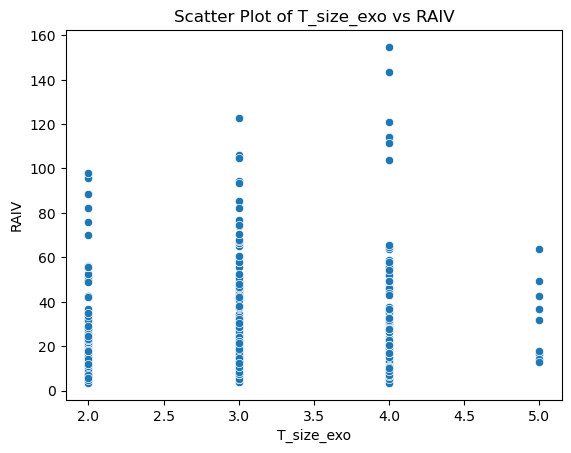

In [21]:
# Create a scatter plot of T_size_exo vs RAIV
sns.scatterplot(data=merged_result, x="T_size_exo", y="RAIV")

# Add a title and labels
plt.title("Scatter Plot of T_size_exo vs RAIV")
plt.xlabel("T_size_exo")
plt.ylabel("RAIV")

# Show the plot
plt.show()

In [22]:
import plotly.graph_objs as go

# Filter merged_result based on RAIV >= 80
merged_result_raiv_80 = merged_result[merged_result['RAIV'] >= 80]

# Create a scatter plot for RAIV < 80
trace_raiv_lt_80 = go.Scatter(
    x=merged_result[merged_result['RAIV'] < 80]['RAIV'],
    y=merged_result[merged_result['RAIV'] < 80]['T_size_exo'],
    mode='markers',
    name='RAIV < 80'
)

# Create a scatter plot for RAIV >= 80
trace_raiv_gte_80 = go.Scatter(
    x=merged_result_raiv_80['RAIV'],
    y=merged_result_raiv_80['T_size_exo'],
    mode='markers',
    name='RAIV >= 80'
)

# Create layout
layout = go.Layout(
    title="Scatter Plot of T_size_exo vs RAIV",
    xaxis=dict(title='RAIV'),
    yaxis=dict(title='T_size_exo')
)

# Create figure and add traces
fig = go.Figure(data=[trace_raiv_lt_80, trace_raiv_gte_80], layout=layout)

# Show plot
fig.show()

## T_size, T_Exophytic , RAIV을 3차원으로 확인

In [23]:
import plotly.graph_objs as go

# Filter merged_result based on RAIV >= 80
merged_result_raiv_80 = merged_result[merged_result['RAIV'] >= 80]

# Create a scatter plot for RAIV < 80
trace_raiv_lt_80 = go.Scatter3d(
    x=merged_result[merged_result['RAIV'] < 80]['RAIV'],
    y=merged_result[merged_result['RAIV'] < 80]['T_exophytic'],
    z=merged_result[merged_result['RAIV'] < 80]['T_size'],
    mode='markers',
    name='RAIV < 80',
    marker=dict(size=5)
)

# Create a scatter plot for RAIV >= 80
trace_raiv_gte_80 = go.Scatter3d(
    x=merged_result_raiv_80['RAIV'],
    y=merged_result_raiv_80['T_exophytic'],
    z=merged_result_raiv_80['T_size'],
    mode='markers',
    name='RAIV >= 80',
    marker=dict(size=5)
)

# Create layout
layout = go.Layout(
    title="3D Scatter Plot of T_exophytic and T_size vs RAIV",
    scene=dict(
        xaxis=dict(title='RAIV'),
        yaxis=dict(title='T_exophytic'),
        zaxis=dict(title='T_size')
    )
)

# Create figure and add traces
fig = go.Figure(data=[trace_raiv_lt_80, trace_raiv_gte_80], layout=layout)

# Show plot
fig.show()

**결론: T_size는 RAIV값에 큰 영향을 끼치는 것 같지가 않다.**

## T_near_ureter , T_Exophytic , RAIV 값을 3차원으로 확인

In [24]:
import plotly.graph_objs as go

# Filter merged_result based on RAIV >= 80
merged_result_raiv_80 = merged_result[merged_result['RAIV'] >= 80]

# Create a scatter plot for RAIV < 80
trace_raiv_lt_80 = go.Scatter3d(
    x=merged_result[merged_result['RAIV'] < 80]['RAIV'],
    y=merged_result[merged_result['RAIV'] < 80]['T_exophytic'],
    z=merged_result[merged_result['RAIV'] < 80]['T_near_Ureter'],
    mode='markers',
    name='RAIV < 80',
    marker=dict(size=5)
)

# Create a scatter plot for RAIV >= 80
trace_raiv_gte_80 = go.Scatter3d(
    x=merged_result_raiv_80['RAIV'],
    y=merged_result_raiv_80['T_exophytic'],
    z=merged_result_raiv_80['T_near_Ureter'],
    mode='markers',
    name='RAIV >= 80',
    marker=dict(size=5)
)

# Create layout
layout = go.Layout(
    title="3D Scatter Plot of T_exophytic and T_near_Ureter vs RAIV",
    scene=dict(
        xaxis=dict(title='RAIV'),
        yaxis=dict(title='T_exophytic'),
        zaxis=dict(title='T_near_Ureter')
    )
)

# Create figure and add traces
fig = go.Figure(data=[trace_raiv_lt_80, trace_raiv_gte_80], layout=layout)

# Show plot
fig.show()


**결론: 오히려 T_size 보다 T_near_urethra 가 유의미한 데이터로 보임**

### T_surface_loc (종양의 표면 위치 lateral_외측 ; Medial_내측(몸 중심 가까이))에 따른 Raiv

In [25]:
import plotly.graph_objs as go

# Filter merged_result based on RAIV >= 80
merged_result_raiv_80 = merged_result[merged_result['RAIV'] >= 80]

# Create a scatter plot for RAIV < 80
trace_raiv_lt_80 = go.Scatter(
    x=merged_result[merged_result['RAIV'] < 80]['RAIV'],
    y=merged_result[merged_result['RAIV'] < 80]['T_surface_loc'],
    mode='markers',
    name='RAIV < 80'
)

# Create a scatter plot for RAIV >= 80
trace_raiv_gte_80 = go.Scatter(
    x=merged_result_raiv_80['RAIV'],
    y=merged_result_raiv_80['T_surface_loc'],
    mode='markers',
    name='RAIV >= 80'
)

# Create layout
layout = go.Layout(
    title="Scatter Plot of T_surface_loc vs RAIV",
    xaxis=dict(title='RAIV'),
    yaxis=dict(title='T_surface_loc')
)

# Create figure and add traces
fig = go.Figure(data=[trace_raiv_lt_80, trace_raiv_gte_80], layout=layout)

# Show plot
fig.show()

# 결론: 이상치와 정보가 있는 값이 아닌 오류값으로 확인됨

---


## 이상치제거X : merged_result 사용 / 단, 원본은 남겨두고 merged_copy라는 변수로 사용하길 권장 (v1버전)
## 이상치제거O : merged_data_80이라는 변수를 제거한 merged_drop 을 사용하세요 (아래에 생성해둠) (v2버전)


RAIV가 80이상인 데이터 따로 변수에 할당해줌

In [26]:
merged_data_80 = merged_result[merged_result['RAIV'] > 80]
merged_data_80

,T_surface_loc,T_Sinus_dt,T_height_loc,T_GM_over,T_size,T_exophytic,T_near_Ureter,T_rel_Ureter,T_APX,Total,T_size_exo,RAIV
serial,,,,,,,,,,,,
11,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,10,2.0,95.7
16,1.0,2.0,1.0,1.0,1.0,2.0,3.0,1.0,2.0,14,3.0,85.4
19,2.0,1.0,2.0,1.0,1.0,3.0,1.0,2.0,2.0,15,4.0,114.0
22,1.0,2.0,1.0,1.0,1.0,3.0,3.0,1.0,1.0,16,4.0,154.8
46,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,11,3.0,94.2
50,1.0,1.0,1.0,1.0,1.0,3.0,1.0,3.0,1.0,13,4.0,111.3
53,2.0,1.0,1.0,1.0,1.0,3.0,1.0,2.0,2.0,14,4.0,103.6
60,1.0,1.0,2.0,1.0,1.0,3.0,1.0,3.0,1.0,14,4.0,143.4
79,1.0,1.0,2.0,1.0,1.0,2.0,3.0,2.0,2.0,14,3.0,93.6


RAIV80이상인 데이터없는 데이터 새로 만들어줌
(merged_data는 살려둠)

## 1. v1 데이터(제거X)

In [27]:
result_copy = merged_result.copy()
result_copy

,T_surface_loc,T_Sinus_dt,T_height_loc,T_GM_over,T_size,T_exophytic,T_near_Ureter,T_rel_Ureter,T_APX,Total,T_size_exo,RAIV
serial,,,,,,,,,,,,
1,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,12,3.0,51.1
2,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,13,3.0,46.1
3,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,10,2.0,14.8
4,1.0,1.0,2.0,2.0,1.0,1.0,3.0,3.0,2.0,13,2.0,19.7
5,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,12,3.0,14.8
...,...,...,...,...,...,...,...,...,...,...,...,...
408,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,12,3.0,21.3
409,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,12,3.0,30.5
410,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,11,3.0,70.7


# 04. 데이터 나누기(train_test_split)

In [28]:
from sklearn.model_selection import train_test_split

X = result_copy.drop(['RAIV'], axis=1)  # 'RAIV_1' 열을 제외한 모든 열 선택
y = result_copy['RAIV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

## 실루엣계수로 최적 군집 개수 확인

Exception in thread Thread-6:
Traceback (most recent call last):
  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\subprocess.py", line 1386, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb1 in position 24: invalid start byte
  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\joblib\externals\loky\backend\context.py", line 202, in _count_physical_cores
    cpu_info = cpu_info.stdout.splitlines()


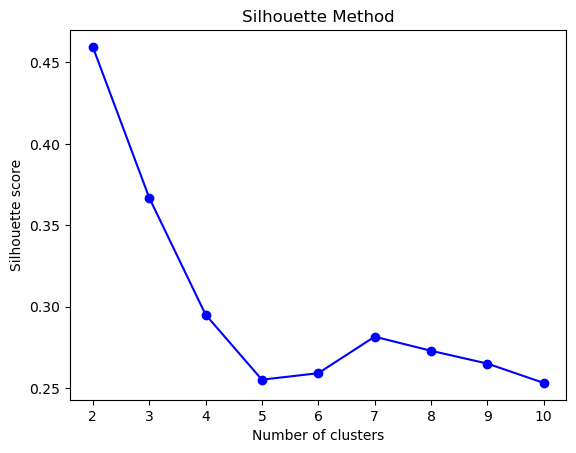

In [29]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 군집수에 따른 실루엣계수를 담을 리스트
silhouette_scores = []

# 2~10까지 군집수를 변화시키며 실루엣계수를 계산
for n_clusters in range(2, 11):
    # KMeans 군집화 수행
    kmeans = KMeans(n_clusters=n_clusters, random_state=13)
    kmeans.fit(X_train)

    # 실루엣계수 계산
    silhouette_score_ = silhouette_score(X_train, kmeans.labels_)
    silhouette_scores.append(silhouette_score_)

# 군집수에 따른 실루엣계수 그래프 그리기
plt.plot(range(2, 11), silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method')
plt.show()


실루엣 점수가 가장 높은 2개가 최적의 군집 수로 판단

## X_train 데이터로 군집 0 과 1로 나눔 (이상치가 포함됨)

In [30]:
# 군집화 수행
kmeans = KMeans(n_clusters=2, random_state=13)
kmeans.fit(X_train)

# 군집 레이블 생성
labels = kmeans.labels_

# 군집 0과 1로 나누기
re_cluster_0 = X_train[labels == 0]
re_cluster_1 = X_train[labels == 1]

# 군집 0과 1 출력
print("\nre_cluster_0:")
print(re_cluster_0.head())
print("\nre_cluster_1:")
print(re_cluster_1.head())


re_cluster_0:
        T_surface_loc  T_Sinus_dt  T_height_loc  T_GM_over  T_size  \
serial                                                               
292               2.0         2.0           2.0        2.0     1.0   
85                2.0         1.0           1.0        1.0     1.0   
345               1.0         2.0           2.0        2.0     2.0   
320               2.0         2.0           1.0        2.0     3.0   
191               1.0         1.0           1.0        1.0     1.0   

        T_exophytic  T_near_Ureter  T_rel_Ureter  T_APX  Total  T_size_exo  
serial                                                                      
292             1.0            3.0           3.0    1.0     15         2.0  
85              2.0            3.0           1.0    2.0     14         3.0  
345             1.0            3.0           2.0    1.0     16         3.0  
320             1.0            3.0           3.0    1.0     18         4.0  
191             3.0            3

### 군집0 과 군집1의 모든 변수들의 분포도를 2차원데이터로 시각화


In [31]:
# Create a list of variable names
variable_names = ['T_surface_loc', 'T_Sinus_dt', 'T_height_loc', 'T_GM_over', 'T_size', 'T_exophytic', 'T_near_Ureter', 'T_rel_Ureter', 'T_APX', 'Total', 'T_size_exo']

# Loop through each variable and create a scatter plot for each cluster
for variable in variable_names:
    # Create a scatter plot for cluster 0
    trace_cluster_0 = go.Scatter(
        x=re_cluster_0[variable],
        y=result_copy['RAIV'],
        mode='markers',
        name='Cluster 0'
    )

    # Create a scatter plot for cluster 1
    trace_cluster_1 = go.Scatter(
        x=re_cluster_1[variable],
        y=result_copy['RAIV'],
        mode='markers',
        name='Cluster 1'
    )

    # Create layout
    layout = go.Layout(
        title="Scatter Plot of {} vs RAIV".format(variable),
        xaxis=dict(title=variable),
        yaxis=dict(title='RAIV')
    )

    # Create figure and add traces
    fig = go.Figure(data=[trace_cluster_0, trace_cluster_1], layout=layout)

    # Show plot
    fig.show()


In [32]:
re_cluster_0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143 entries, 292 to 346
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   T_surface_loc  143 non-null    float64
 1   T_Sinus_dt     143 non-null    float64
 2   T_height_loc   143 non-null    float64
 3   T_GM_over      143 non-null    float64
 4   T_size         143 non-null    float64
 5   T_exophytic    143 non-null    float64
 6   T_near_Ureter  143 non-null    float64
 7   T_rel_Ureter   143 non-null    float64
 8   T_APX          143 non-null    float64
 9   Total          143 non-null    int64  
 10  T_size_exo     143 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 13.4 KB


In [33]:
re_cluster_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 166 to 80
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   T_surface_loc  168 non-null    float64
 1   T_Sinus_dt     168 non-null    float64
 2   T_height_loc   168 non-null    float64
 3   T_GM_over      168 non-null    float64
 4   T_size         168 non-null    float64
 5   T_exophytic    168 non-null    float64
 6   T_near_Ureter  168 non-null    float64
 7   T_rel_Ureter   168 non-null    float64
 8   T_APX          168 non-null    float64
 9   Total          168 non-null    int64  
 10  T_size_exo     168 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 15.8 KB


## 군집 간의 차이(이미지)

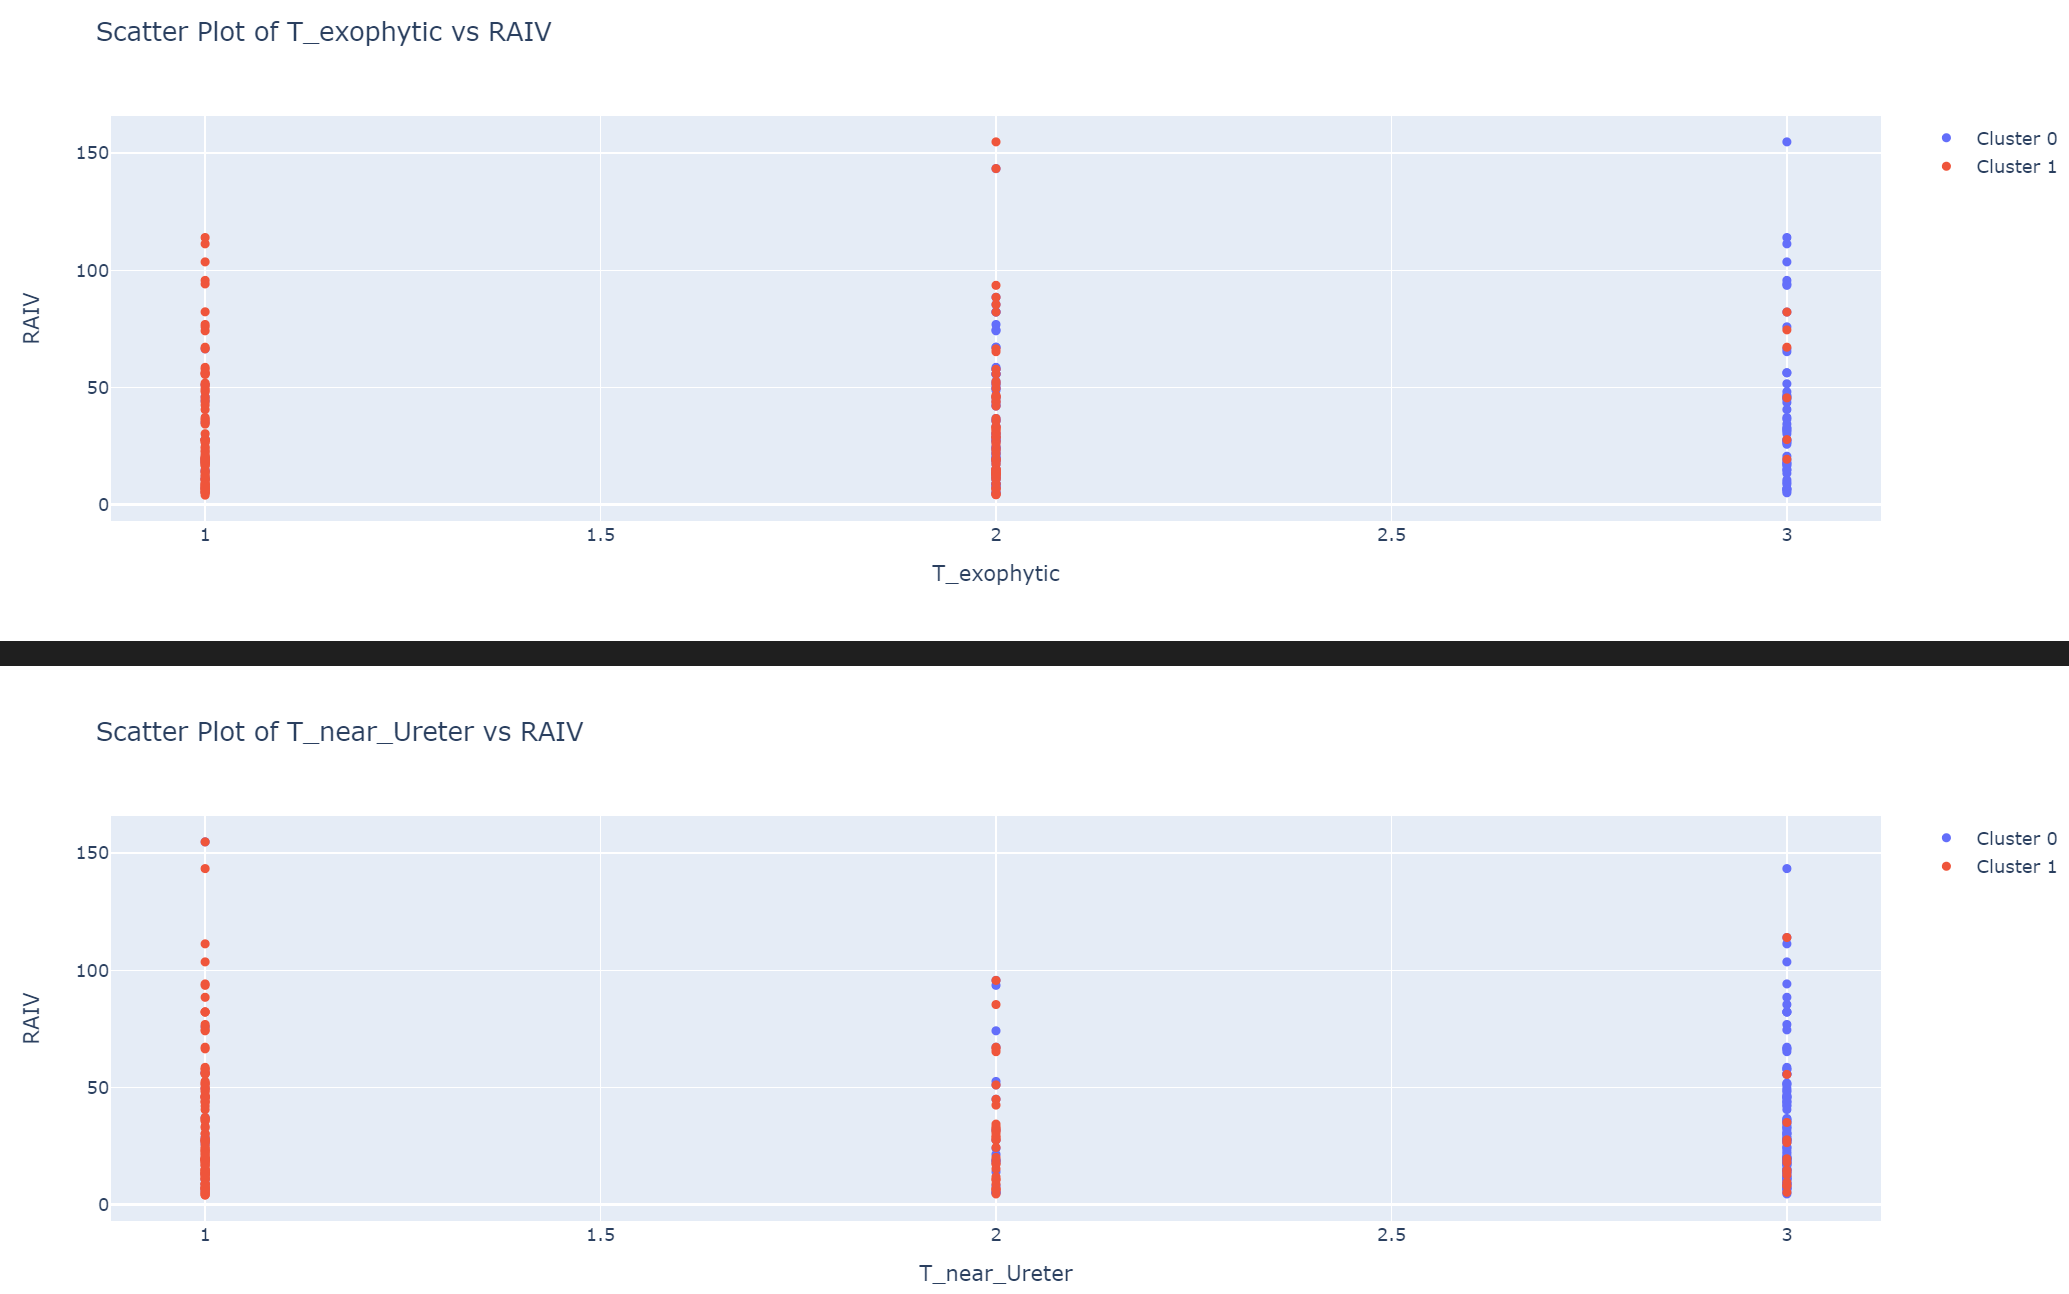

In [34]:
from IPython.display import Image

Image(filename='../data/v1_1.png')

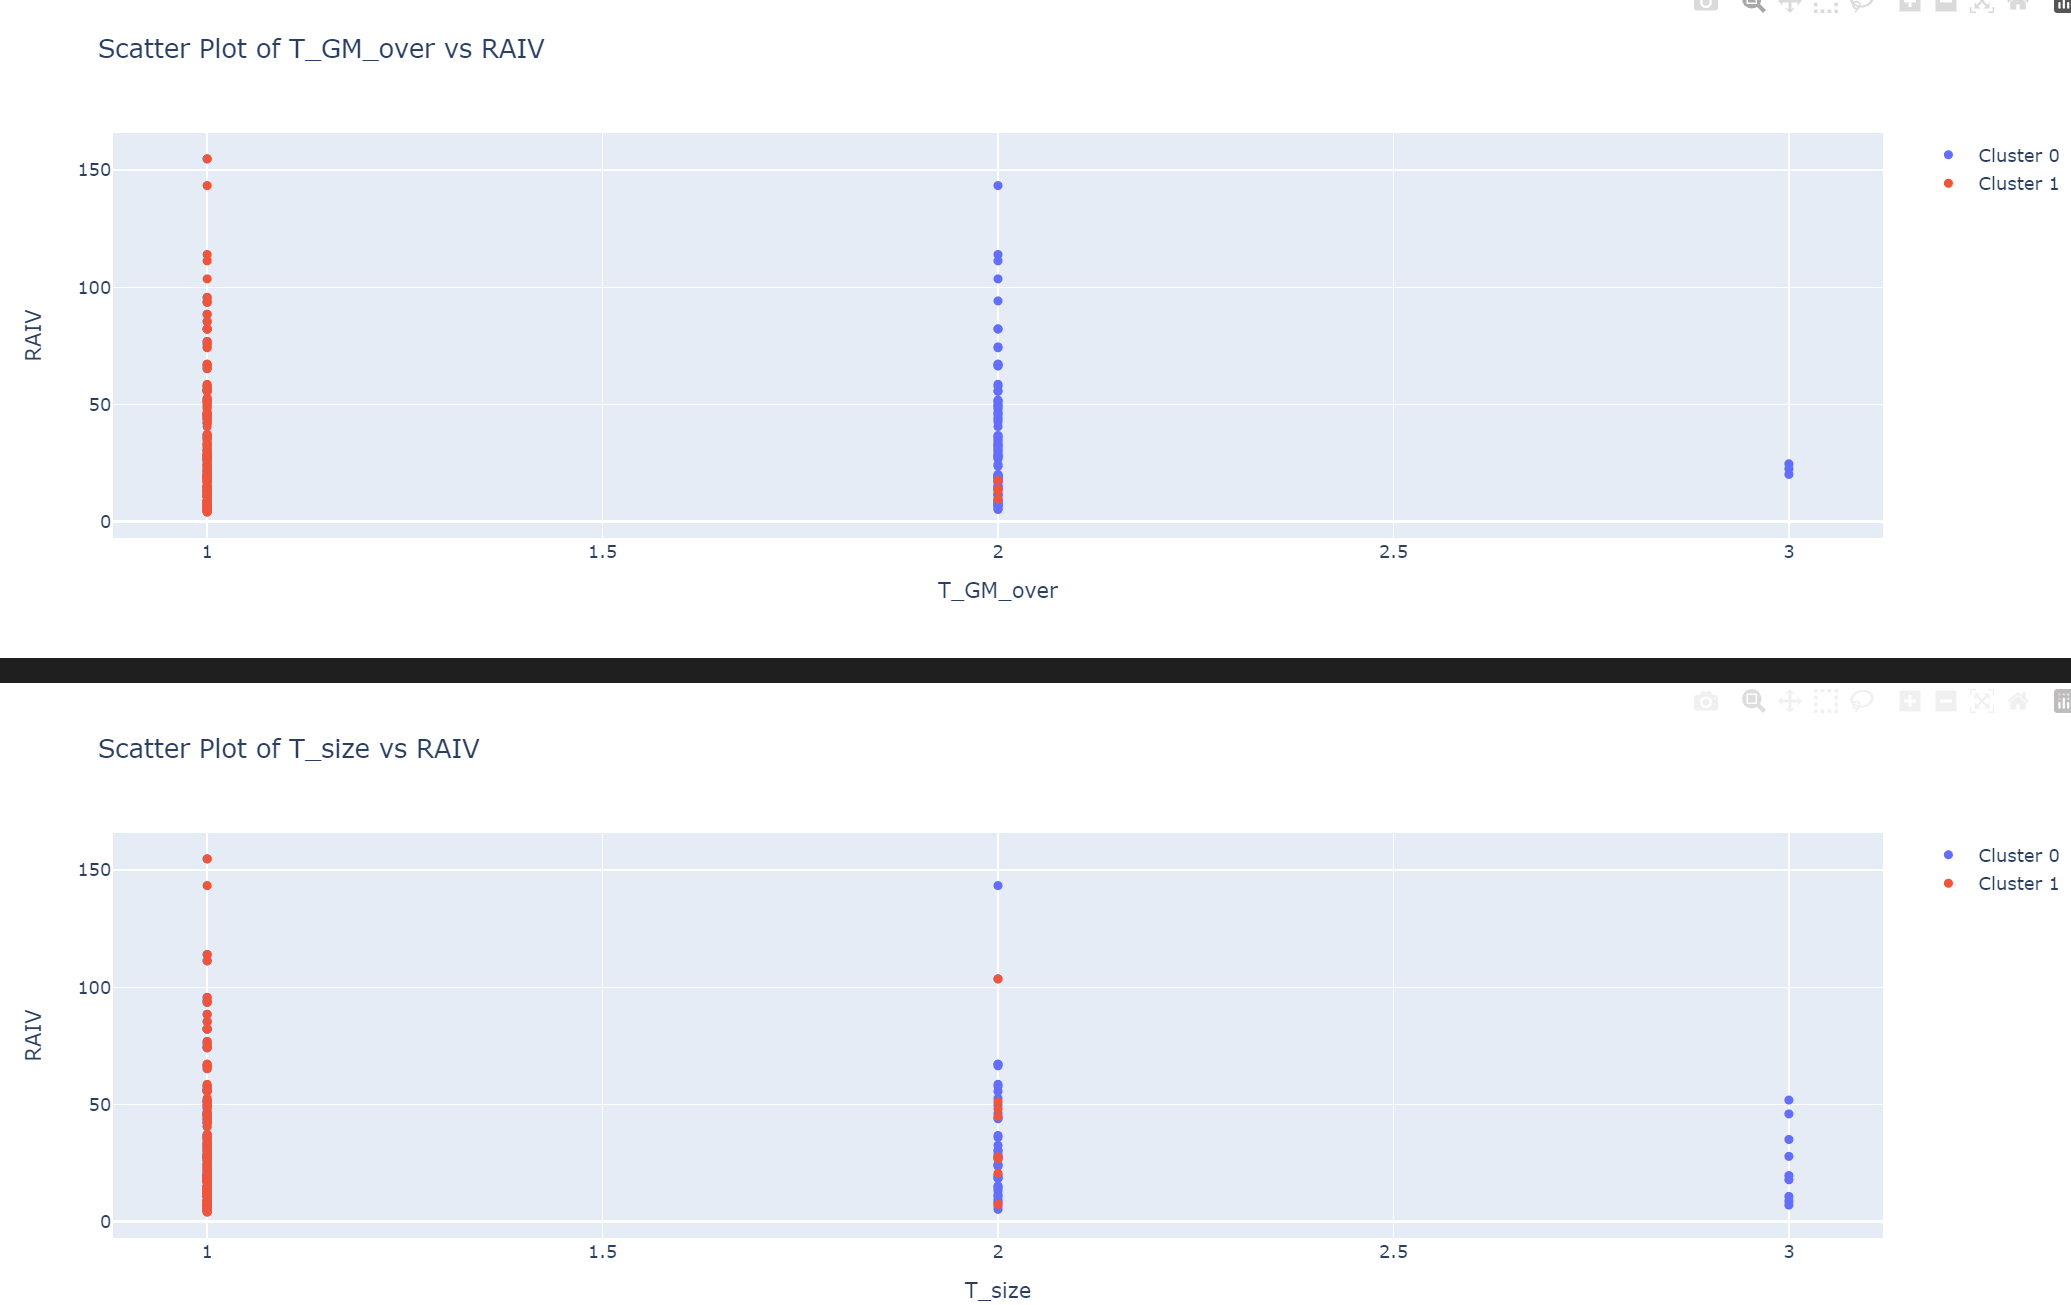

In [35]:
Image(filename='../data/v1_2.png')

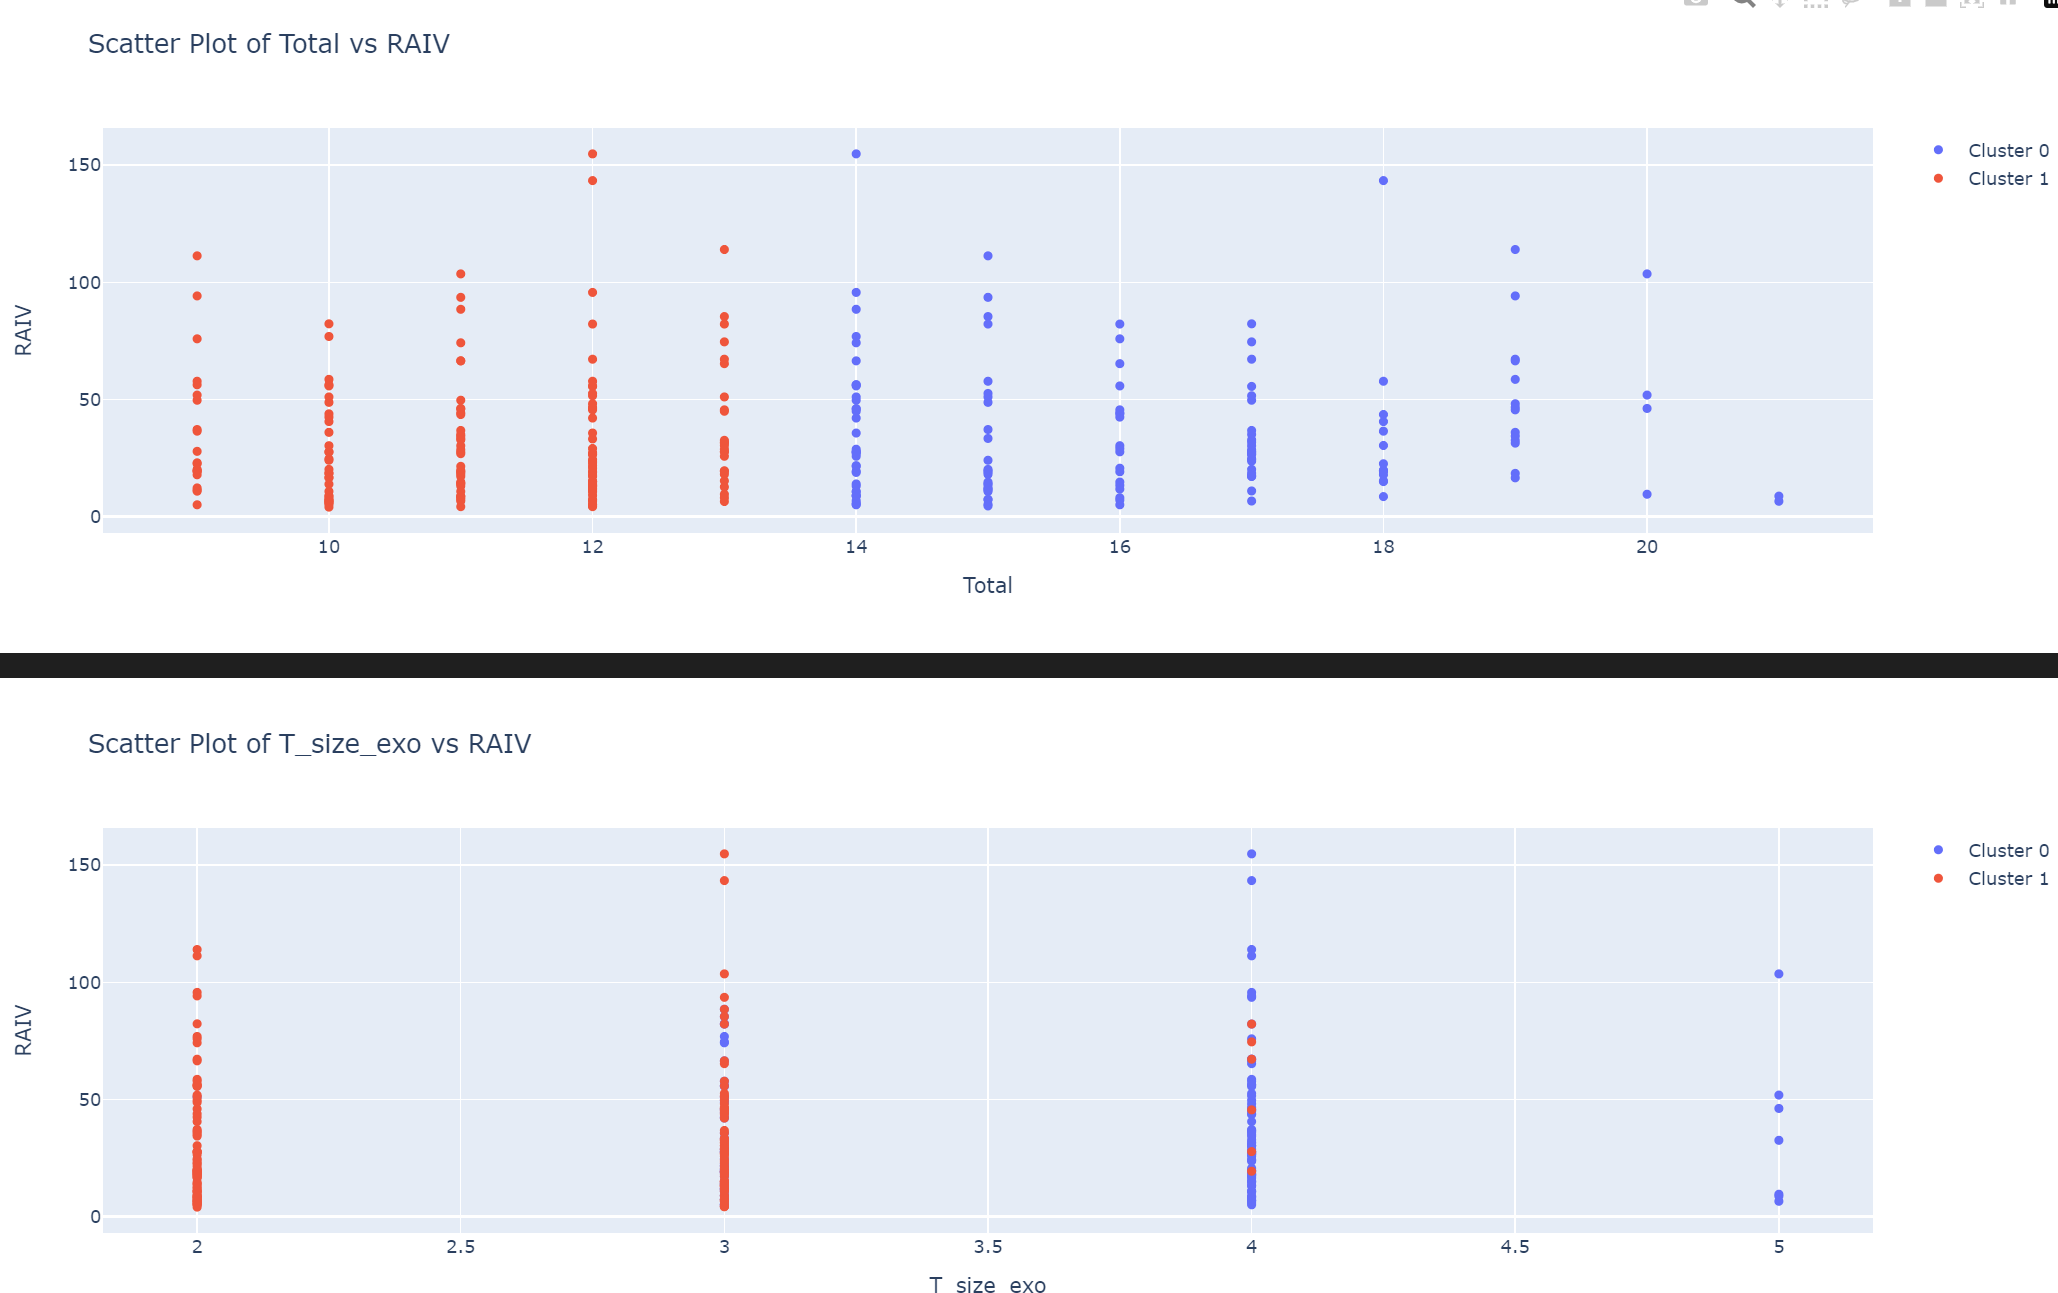

In [36]:
Image(filename='../data/v1_3.png')

## 데이터비율
v1 이상치를 제거하지 않은 데이터 : 군집0 < 군집1 (143:168)